In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time, ast, os
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)
START_POI = 0
END_POI = 400
START_DATE = '2018-12-31'
TOTAL_DAYS = 400
TRAIN_RATIO = 0.5
VALID_RATIO = 0.45
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)
WINDOW_SIZE = 24
HORIZON = 6

In [5]:
class bounding_box:
    def __init__(self, _lat_min, _lon_min,_lat_max,_lon_max):
        self.lat_min = _lat_min
        self.lon_min = _lon_min
        self.lat_max = _lat_max
        self.lon_max = _lon_max


class stat_collector:
    def __init__(self):
        self.parquet_file_count=0
        self.data_record_count = 0
        self.memory_usage_in_GB = 0		#gives an estimate of the total RAM usage if all files were read into memory at the same time.
        self.unique_device_count = 0
        self.avg_pos_acc = 0
        self.starting_time = time.process_time()
        self.elapsed_time = time.process_time()
        self.unique_geohash_count = 0
        
def load_poi_db(HT_range=0.2, ht_lat=29.749907, ht_lon=-95.358421):
    HT_box = bounding_box(ht_lat - HT_range, ht_lon - HT_range, ht_lat + HT_range, ht_lon + HT_range)

    bbox = HT_box
    poi_folder = "/storage/dataset/poi_haowen/CoreRecords-CORE_POI-2019_03-2020-03-25/"
    poi_columns = ["safegraph_place_id", "parent_safegraph_place_id", "location_name", "safegraph_brand_ids", "brands",
                   "top_category", "sub_category", "naics_code", "latitude", "longitude", "street_address", "city",
                   "region", "postal_code", "iso_country_code", "phone_number", "open_hours", "category_tags"]
    files = os.listdir(poi_folder)


    poi_s = stat_collector()
    poi_db = pd.DataFrame(columns=poi_columns)
    for f in files:
        if f[-3:] == 'csv' and 'brand' not in f:
            print(f)
            df = pd.read_csv(poi_folder + f)
            df = df[
                (df['latitude'] > bbox.lat_min) & (df['latitude'] < bbox.lat_max) & (df['longitude'] > bbox.lon_min) & (
                            df['longitude'] < bbox.lon_max)]
            poi_db = poi_db.append(df, ignore_index=True, sort=False)
            poi_s.memory_usage_in_GB += df.memory_usage(deep=True).sum() / 1000000000
            poi_s.data_record_count += df.shape[0]
            poi_s.parquet_file_count += 1
    return poi_db, poi_s


def get_merged_df(csv_path, start_row, end_row):

    #start = time.time()
    merge_df = pd.read_csv(csv_path)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.iloc[start_row:end_row]
    #print(merge_df)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: x[:TOTAL_DAYS*24])
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: x[:TOTAL_DAYS])
    return merge_df


In [6]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    
    mask = (v < 1E-5)
    percentage = np.abs(v_ - v) / np.abs(v)
    percentage = np.where(percentage > 5, 5, percentage) # TODO remove this
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)


def MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    mape = (np.abs(v_ - v) / np.abs(v)+1e-5).astype(np.float64)
    mape = np.where(mape > 5, 5, mape)
    return np.mean(mape, axis)


def RMSE(v, v_, axis=None):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)




def MAE(v, v_, axis=None):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAE averages on all elements of input.
    '''

    return np.mean(np.abs(v_ - v), axis).astype(np.float64)


def evaluate(y, y_hat, by_step=False, by_node=False):
    '''
    :param y: array in shape of [count, time_step, node].
    :param y_hat: in same shape with y.
    :param by_step: evaluate by time_step dim.
    :param by_node: evaluate by node dim.
    :return: array of mape, mae and rmse.
    '''
    if not by_step and not by_node:
        return masked_MAPE(y, y_hat), MAE(y, y_hat), RMSE(y, y_hat)
    if by_step and by_node:
        return masked_MAPE(y, y_hat, axis=0), MAE(y, y_hat, axis=0), RMSE(y, y_hat, axis=0)
    if by_step:
        return masked_MAPE(y, y_hat, axis=(0, 2)), MAE(y, y_hat, axis=(0, 2)), RMSE(y, y_hat, axis=(0, 2))
    if by_node:
        return masked_MAPE(y, y_hat, axis=(0, 1)), MAE(y, y_hat, axis=(0, 1)), RMSE(y, y_hat, axis=(0, 1))

In [7]:
csv_path_weekly = '/home/users/arash/datasets/safegraph/weekly_patterns_2018-12-31_2020-06-08_Houston.csv'
csv_poi_info = '/home/users/arash/datasets/safegraph/core_poi_info_2018-12-31_2020-06-08.csv'
weekly_patterns = get_merged_df(csv_path_weekly, START_POI, END_POI)
poi_info = pd.read_csv(csv_poi_info)
poi_df = pd.merge(weekly_patterns, poi_info, on='safegraph_place_id', how='inner')
poi_df.head(3)

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall


In [8]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-07-20T00:00:00.000000000', '2019-07-20T01:00:00.000000000',
       '2019-07-20T02:00:00.000000000', ...,
       '2020-01-14T16:00:00.000000000', '2020-01-14T17:00:00.000000000',
       '2020-01-14T18:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
poi_db, poi_s = load_poi_db(HT_range=1.5)
poi_df = poi_df.merge(poi_db, how='left', on='safegraph_place_id', suffixes=('', '_y'))
poi_df.drop(poi_df.filter(regex='_y$').columns, axis=1, inplace=True)
del poi_db
poi_df.head(3)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN


In [11]:
poi_df['visits_by_each_hour'] = poi_df['visits_by_each_hour'].apply(lambda x: np.array(x))
poi_df['visits_by_day'] = poi_df['visits_by_day'].apply(lambda x: np.array(x))
agg_df = poi_df.groupby('top_category').agg({'visits_by_day': 'sum',
                                    'visits_by_each_hour': 'sum',
                                    'raw_visit_counts': 'sum',
                                    'safegraph_place_id': 'count'})
agg_df.columns = ['daily_visits', 'hourly_visits', 'raw_visits', 'count']
agg_df.head()

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Amusement Parks and Arcades,"[167, 151, 145, 140, 178, 212, 114, 79, 90, 94...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 13, 15, 25, 18,...",56425,1
Automobile Dealers,"[423, 255, 425, 406, 465, 395, 195, 362, 426, ...","[0, 0, 0, 0, 1, 1, 7, 11, 14, 16, 24, 40, 35, ...",183807,3
Automotive Equipment Rental and Leasing,"[30, 0, 115, 146, 106, 11, 3, 162, 187, 213, 2...","[0, 0, 1, 0, 1, 3, 1, 5, 6, 1, 1, 1, 3, 5, 0, ...",52544,1
Book Stores and News Dealers,"[5, 5, 35, 38, 84, 15, 9, 44, 121, 90, 113, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...",119990,1
Building Material and Supplies Dealers,"[1148, 895, 1081, 1210, 1414, 1455, 1255, 1035...","[4, 2, 3, 3, 11, 11, 18, 29, 47, 77, 115, 124,...",904977,15


In [12]:
agg_df.loc[agg_df['count'] == 2]

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Clothing Stores,"[270, 185, 344, 370, 433, 197, 157, 335, 367, ...","[1, 0, 0, 1, 0, 1, 5, 21, 10, 11, 16, 32, 23, ...",140180,2
Furniture Stores,"[491, 404, 360, 351, 445, 602, 617, 284, 219, ...","[0, 0, 1, 1, 1, 0, 3, 5, 6, 17, 47, 42, 49, 64...",196754,2
Home Health Care Services,"[268, 153, 269, 280, 342, 181, 185, 286, 291, ...","[3, 6, 5, 4, 7, 5, 23, 23, 29, 12, 8, 14, 14, ...",142355,2


In [13]:
def get_df_timeseries(df, category, time_index=time_span):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['hourly_visits']).set_index(time_index)[['hourly_visits']].rename(columns=dict(hourly_visits='visits'))
    return ts_df

In [14]:
def get_preds_timeseries(df, category, time_index):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['predictions']).set_index(time_index)[['predictions']].rename(columns=dict(predictions='visits'))
    return ts_df

In [15]:
get_df_timeseries(agg_df, 'Home Health Care Services')

,visits
2018-12-31 00:00:00,3
2018-12-31 01:00:00,6
2018-12-31 02:00:00,5
2018-12-31 03:00:00,4
2018-12-31 04:00:00,7
...,...
2020-02-03 19:00:00,7
2020-02-03 20:00:00,5
2020-02-03 21:00:00,6
2020-02-03 22:00:00,5


In [16]:
agg_df.sort_values(by='raw_visits', ascending=False)

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Lessors of Real Estate,"[35904, 22603, 27591, 31650, 36885, 37725, 313...","[143, 92, 79, 93, 136, 190, 258, 510, 818, 138...",16536792,126
Support Activities for Air Transportation,"[13711, 14815, 18313, 16938, 16584, 14506, 175...","[157, 139, 124, 263, 520, 637, 702, 672, 907, ...",7505248,7
Restaurants and Other Eating Places,"[5280, 2909, 6454, 7087, 6941, 4178, 3763, 610...","[56, 65, 51, 53, 49, 104, 316, 370, 317, 326, ...",3325535,33
"General Merchandise Stores, including Warehouse Clubs and Supercenters","[6226, 3469, 4717, 5690, 5828, 6231, 6123, 481...","[61, 36, 27, 27, 35, 46, 79, 87, 155, 269, 398...",3215560,29
Elementary and Secondary Schools,"[1186, 522, 1849, 1920, 2536, 1327, 1798, 3533...","[8, 10, 11, 4, 8, 24, 83, 126, 114, 120, 106, ...",2942135,26
Gasoline Stations,"[3460, 3446, 5102, 4881, 4661, 3676, 3964, 389...","[25, 26, 17, 38, 80, 116, 177, 207, 287, 165, ...",2193248,11
Traveler Accommodation,"[3627, 3675, 4500, 4352, 4236, 3982, 4047, 344...","[38, 22, 16, 43, 81, 116, 166, 195, 266, 144, ...",2023926,9
Grocery Stores,"[3973, 1956, 2323, 2658, 2845, 3113, 3220, 263...","[9, 6, 13, 14, 33, 23, 38, 86, 105, 169, 261, ...",1589015,23
General Medical and Surgical Hospitals,"[1665, 1139, 2938, 3323, 3120, 1372, 1352, 276...","[19, 21, 14, 28, 22, 35, 125, 115, 100, 98, 10...",1508712,10


### Checking Total Visits Volume

### Checking the Prediction Visit Pattersn

In [17]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [18]:
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

In [20]:
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-07-20T00:00:00.000000000', '2019-07-20T01:00:00.000000000',
       '2019-07-20T02:00:00.000000000', ...,
       '2020-01-14T16:00:00.000000000', '2020-01-14T17:00:00.000000000',
       '2020-01-14T18:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',').T
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',').T

In [22]:
preds_df = poi_df.copy()
preds_df['predictions'] = pd.Series(list(preds_data))
preds_df['targets'] = pd.Series(list(target_data))
preds_df

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags,predictions,targets
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN,"[102.21515518015903, 71.50762018283285, 77.194...","[65.00001011245058, 54.00001282331641, 34.0000..."
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN,"[35.36262133801749, 16.777962752426404, 7.4909...","[2.0000047786540733, 18.000001522080154, 2.000..."
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN,"[22.436058572688907, 17.889513014936398, 18.18...","[22.000000606642118, 15.999999910875474, 14.00..."
3,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN,sg:7dea7a58e8424b22ba0d0b96bc1b6cc9,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,29.986670,-95.337942,NaN,NaN,NaN,"[22.11362031464384, 16.49107856552301, 20.6435...","[0.9999962102655786, 16.999998252417086, 2.000..."
4,sg:360d88ef2ced4be180ea24290b9f9df4,"[2410, 2607, 3235, 2913, 2806, 2217, 3011, 217...","[28, 45, 53, 36, 94, 116, 104, 132, 103, 189, ...",1240632,William P Hobby Airport,7800 Airport Blvd,Houston,TX,77061,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.646145,-95.277014,1.713640e+10,NaN,NaN,"[46.337592436895676, 16.015089142713236, 20.30...","[41.99999758446309, 37.000002015457795, 8.9999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,sg:18b3905a242544279285792988b7e502,"[94, 77, 93, 86, 113, 133, 98, 78, 89, 72, 94,...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 6, 10, 12, 12, ...",48653,Target,300 Meyerland Plaza Mall,Houston,TX,77096,US,SG_BRAND_42aefbae01d2dfd981f7da7d823d689e,Target,sg:2a7741c069e84897b44a806033428829,Department Stores,Department Stores,452210.0,29.687158,-95.462103,NaN,"{ ""Mon"": [[""8:00"", ""23:00""]], ""Tue"": [[""8:00"",...",NaN,"[0.19960695035583775, 0.04679147807554118, 0.0...","[-4.614630988442059e-08, -4.614630988442059e-0..."
396,sg:96ff5ed1e94843658944043e3843ebf5,"[145, 76, 99, 97, 80, 75, 89, 75, 90, 84, 91, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 7, 11, 7, 14, 8, 1...",48540,Kroger,12222 Jones Rd,Houston,TX,77070,US,SG_BRAND_1f852a23da4b7250,Kroger,sg:5982c58cfc3b4c9f82a9be4e29517b06,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,29.951781,-95.582386,1.832913e+10,"{ ""Mon"": [[""6:00"", ""24:00""]], ""Tue"": [[""6:00"",...",NaN,"[0.1788156944404955, -0.1504536148779927, -0.1...","[-5.284727455645566e-08, -5.284727455645566e-0..."
397,sg:748292b1cf674382925052a9a9a0946a,"[4, 0, 39, 23, 30, 6, 8, 26, 42, 44, 51, 60, 3...","[0, 0, 0, 

In [23]:
preds_agg_df = preds_df.groupby('top_category').agg({'predictions': 'sum',
                                                   'targets': 'sum',
                                                   'visits_by_day': 'sum',
                                                    'visits_by_each_hour': 'sum',
                                                    'raw_visit_counts': 'sum',
                                                    'safegraph_place_id': 'count'})
preds_agg_df.columns = ['predictions', 'targets','daily_visits', 'hourly_visits', 'raw_visits', 'count']
preds_agg_df.head()

,predictions,targets,daily_visits,hourly_visits,raw_visits,count
top_category,,,,,,
Amusement Parks and Arcades,"[0.5727236042560033, 0.8337163216587804, 0.961...","[7.340700403091205e-08, 1.0000001064085877, 7....","[167, 151, 145, 140, 178, 212, 114, 79, 90, 94...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 13, 15, 25, 18,...",56425,1
Automobile Dealers,"[-0.300703509104304, -0.6262268449019075, -0.4...","[-1.9442063159402778e-07, -1.9442063159402778e...","[423, 255, 425, 406, 465, 395, 195, 362, 426, ...","[0, 0, 0, 0, 1, 1, 7, 11, 14, 16, 24, 40, 35, ...",183807,3
Automotive Equipment Rental and Leasing,"[-0.2858693789789273, -0.2823082378243056, -0....","[-4.703201916811395e-08, -4.703201916811395e-0...","[30, 0, 115, 146, 106, 11, 3, 162, 187, 213, 2...","[0, 0, 1, 0, 1, 3, 1, 5, 6, 1, 1, 1, 3, 5, 0, ...",52544,1
Book Stores and News Dealers,"[-1.302916334002994, -1.5055786485596094, -1.4...","[1.0000003694008974, 9.03327883605698e-08, 9.0...","[5, 5, 35, 38, 84, 15, 9, 44, 121, 90, 113, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...",119990,1
Building Material and Supplies Dealers,"[4.359739924894168, 4.4925523182261085, 4.7324...","[2.0000001625437633, 4.000000351692297, 1.9999...","[1148, 895, 1081, 1210, 1414, 1455, 1255, 1035...","[4, 2, 3, 3, 11, 11, 18, 29, 47, 77, 115, 124,...",904977,15


In [24]:
total_visits_df = pd.DataFrame(agg_df['hourly_visits'].sum()).rename(columns={0:'visits'})
total_visits_df = total_visits_df.set_index(time_span)
total_visits_df

,visits
2018-12-31 00:00:00,562
2018-12-31 01:00:00,475
2018-12-31 02:00:00,399
2018-12-31 03:00:00,618
2018-12-31 04:00:00,1035
...,...
2020-02-03 19:00:00,4087
2020-02-03 20:00:00,2633
2020-02-03 21:00:00,1522
2020-02-03 22:00:00,1057


In [25]:
total_preds_visits_df = pd.DataFrame(preds_agg_df['predictions'].sum()).rename(columns={0:'visits'})
total_preds_visits_df = total_preds_visits_df.set_index(valid_dates)
total_preds_visits_df

,visits
2019-07-20 00:00:00,818.680533
2019-07-20 01:00:00,525.485360
2019-07-20 02:00:00,477.799433
2019-07-20 03:00:00,621.891604
2019-07-20 04:00:00,1068.784420
...,...
2020-01-14 14:00:00,6116.681193
2020-01-14 15:00:00,5857.383536
2020-01-14 16:00:00,5662.759559
2020-01-14 17:00:00,4095.905079


In [31]:
def plot_agg_results(main_df, preds_df, name):
    plt.style.use('fivethirtyeight')
    #daily
    ax = main_df.resample('1D').sum().plot(figsize=(16, 8))
    preds_df.resample('1D').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Daily {name} Visits Number')
    plt.savefig(f"img/Aug 25/Old/daily_visits_num_to_cat_{name}.png", bbox_inches = 'tight')
    
    #weekly
    ax = main_df.resample('1W').sum().plot(figsize=(16, 8))
    preds_df.resample('1W').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Weekly {name} Visits Number')
    plt.savefig(f"img/Aug 25/Old/weekly_visits_num_to_cat_{name}.png", bbox_inches = 'tight')

    
    #monthly
    ax = main_df.resample('1M').sum().plot(figsize=(16, 8))
    preds_df.resample('1M').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Monthly {name} Visits Number')
    plt.savefig(f"img/Aug 25/Old/monthly_visits_num_to_cat_{name}.png", bbox_inches = 'tight')


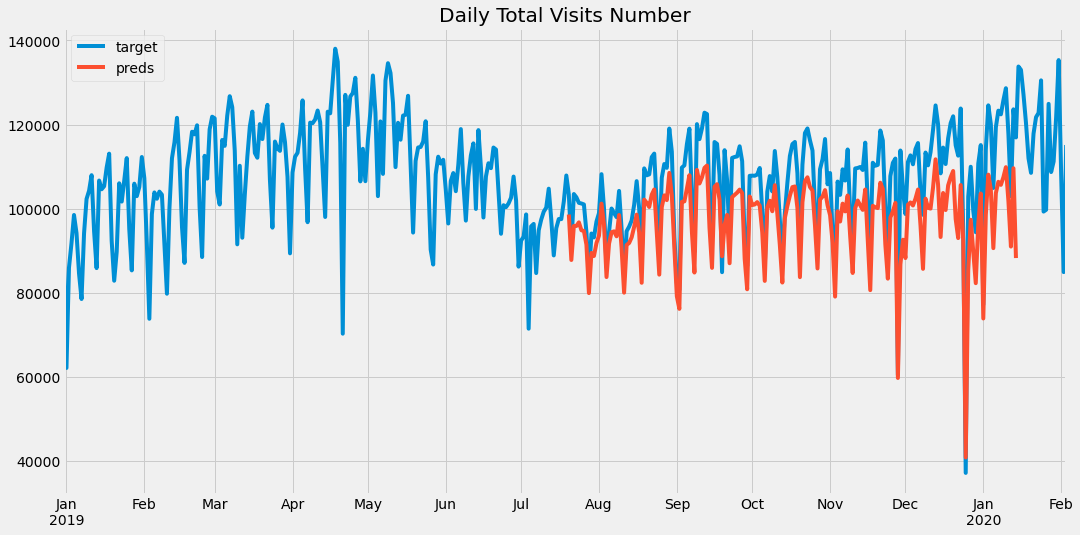

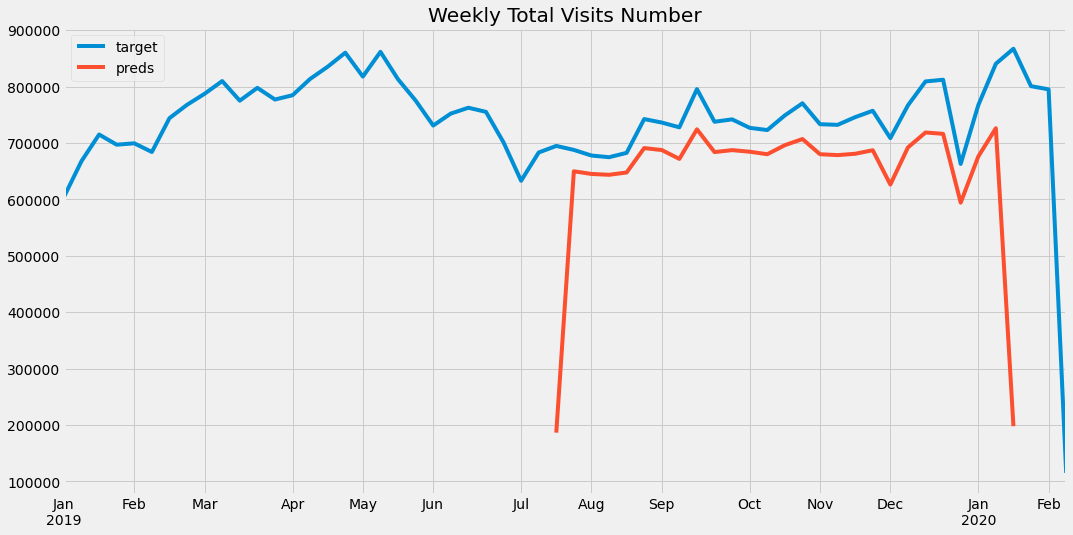

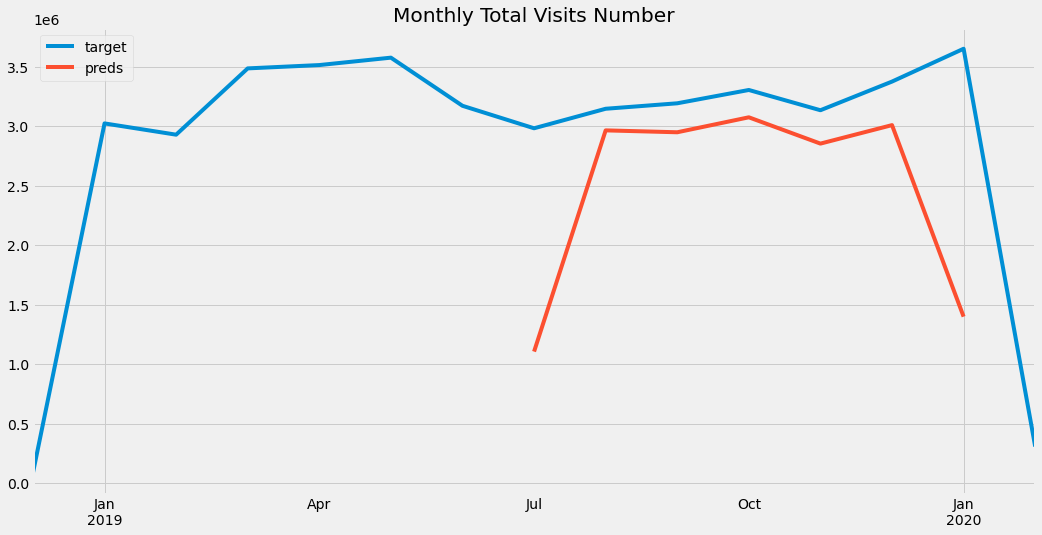

In [32]:
plot_agg_results(total_visits_df, total_preds_visits_df, 'Total')

### Checking Grocery Stores' Patterns

In [33]:
groc_df = get_df_timeseries(agg_df, 'Grocery Stores')
groc_df

,visits
2018-12-31 00:00:00,9
2018-12-31 01:00:00,6
2018-12-31 02:00:00,13
2018-12-31 03:00:00,14
2018-12-31 04:00:00,33
...,...
2020-02-03 19:00:00,182
2020-02-03 20:00:00,91
2020-02-03 21:00:00,62
2020-02-03 22:00:00,47


In [34]:
preds_groc_df = get_preds_timeseries(preds_agg_df, 'Grocery Stores', valid_dates)
preds_groc_df

,visits
2019-07-20 00:00:00,17.739091
2019-07-20 01:00:00,10.169527
2019-07-20 02:00:00,9.756444
2019-07-20 03:00:00,11.59466
2019-07-20 04:00:00,15.447252
...,...
2020-01-14 14:00:00,183.626379
2020-01-14 15:00:00,211.066824
2020-01-14 16:00:00,223.968438
2020-01-14 17:00:00,172.161211


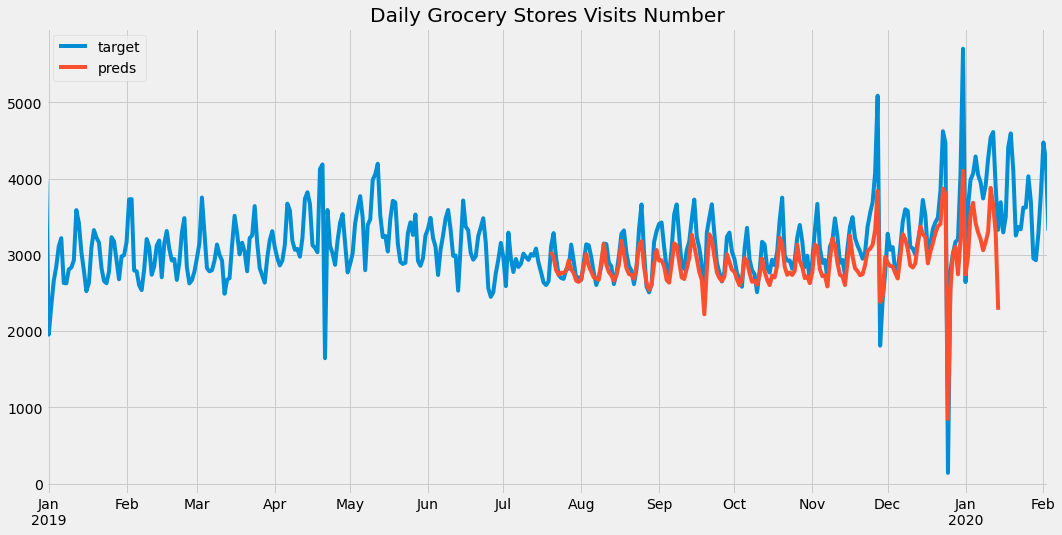

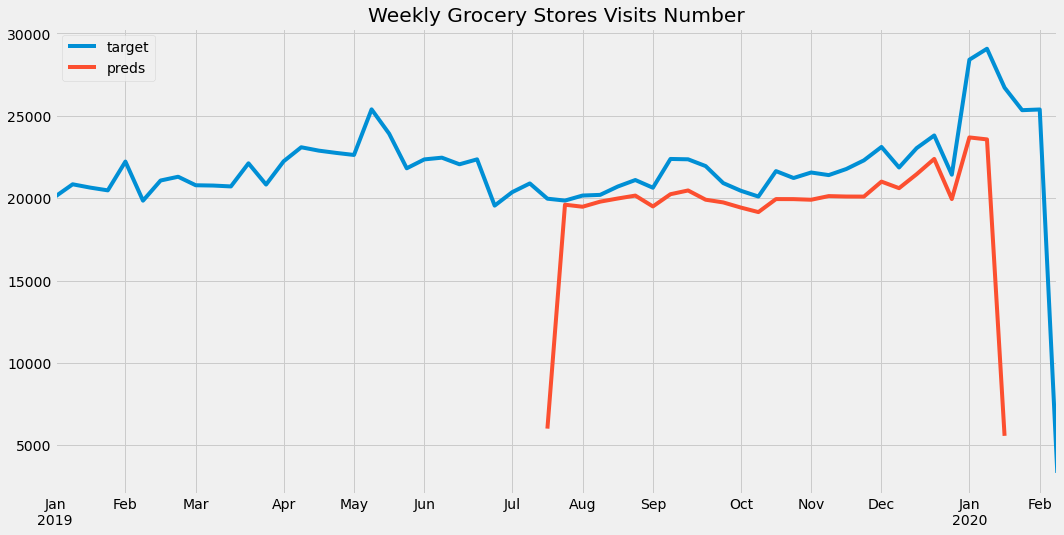

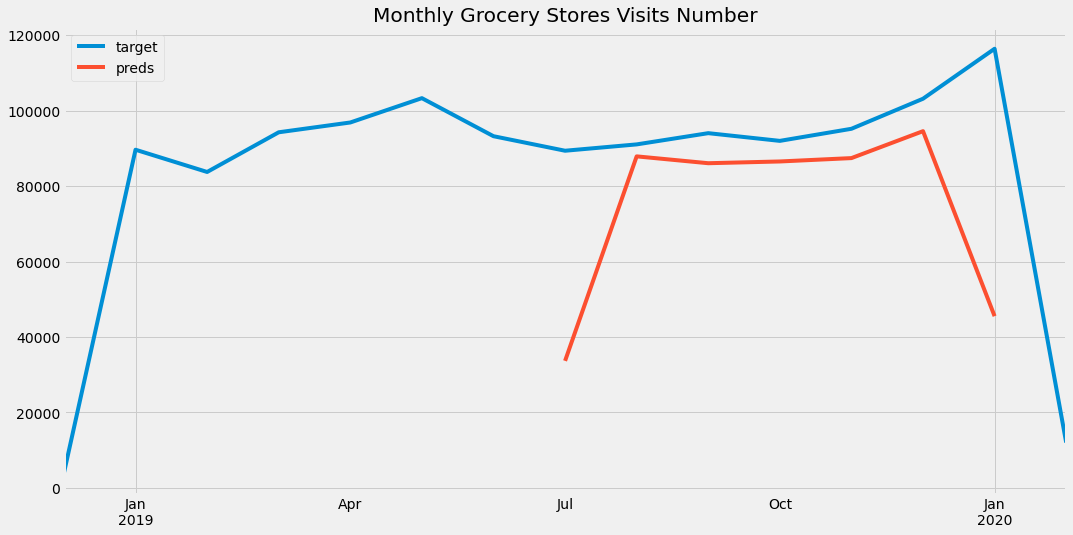

In [35]:
plot_agg_results(groc_df, preds_groc_df, 'Grocery Stores')

### Checking Gas Stations' Patterns

In [36]:
gas_df = get_df_timeseries(agg_df, 'Gasoline Stations')
gas_df

,visits
2018-12-31 00:00:00,25
2018-12-31 01:00:00,26
2018-12-31 02:00:00,17
2018-12-31 03:00:00,38
2018-12-31 04:00:00,80
...,...
2020-02-03 19:00:00,179
2020-02-03 20:00:00,166
2020-02-03 21:00:00,65
2020-02-03 22:00:00,65


In [37]:
preds_gas_df = get_preds_timeseries(preds_agg_df, 'Gasoline Stations', valid_dates)
preds_gas_df

,visits
2019-07-20 00:00:00,43.581407
2019-07-20 01:00:00,23.001803
2019-07-20 02:00:00,12.453005
2019-07-20 03:00:00,29.969577
2019-07-20 04:00:00,62.83579
...,...
2020-01-14 14:00:00,277.539388
2020-01-14 15:00:00,265.835366
2020-01-14 16:00:00,242.454233
2020-01-14 17:00:00,186.350419


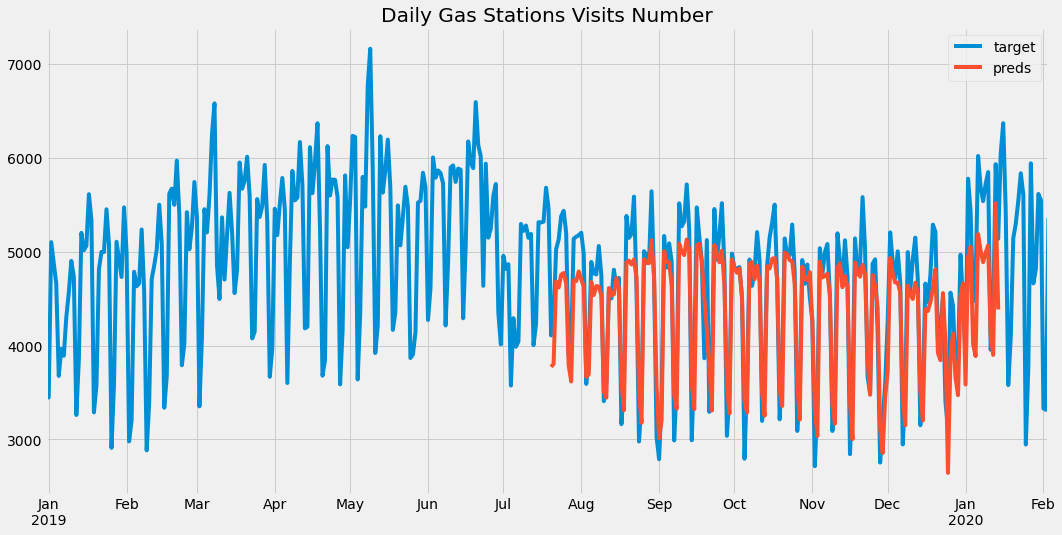

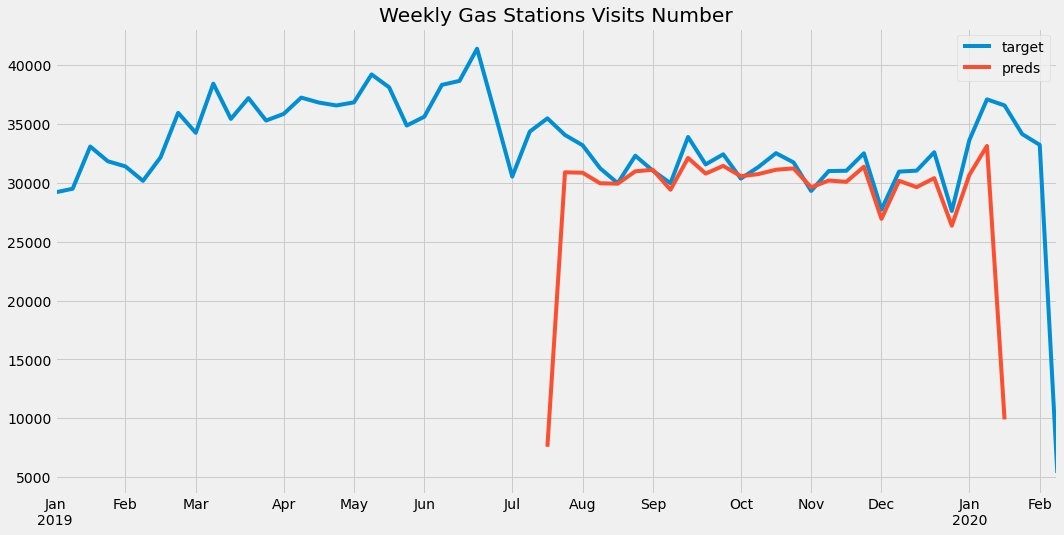

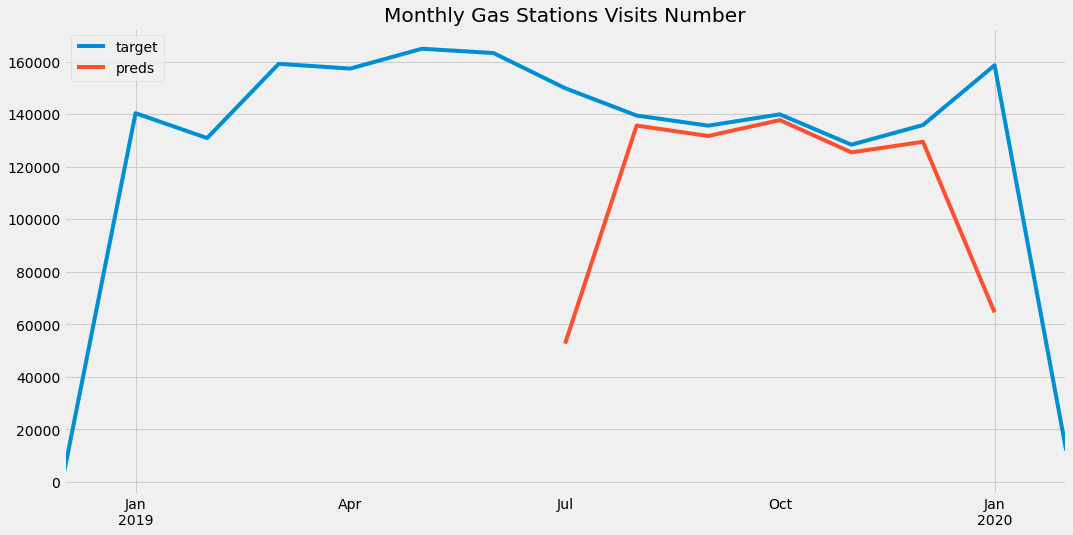

In [38]:
plot_agg_results(gas_df, preds_gas_df, 'Gas Stations')

<AxesSubplot:>

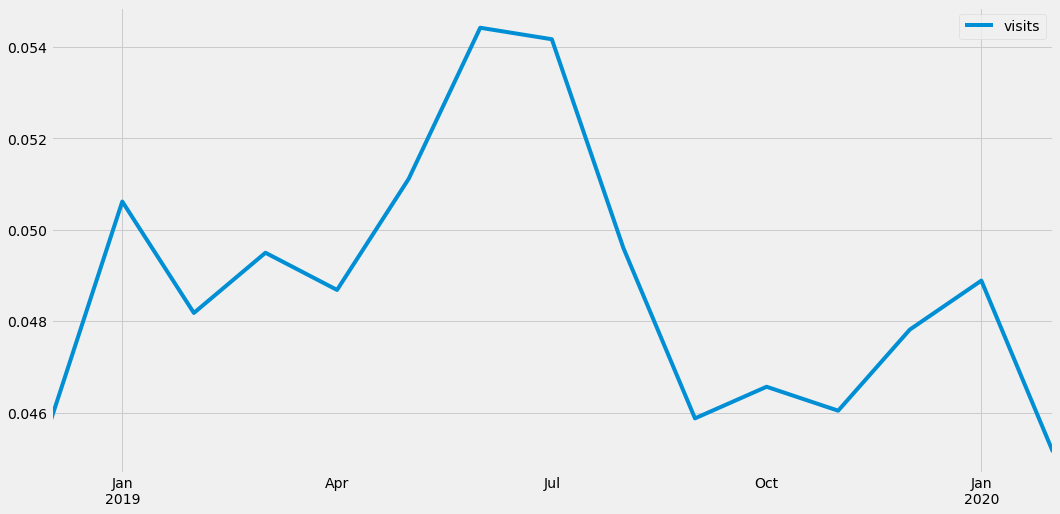

In [40]:
pd.DataFrame(gas_df['visits'] / total_visits_df['visits']).resample('1M').mean().plot(figsize=(16, 8))

### Checking Schools' Visit Patterns

In [41]:
sch_df = get_df_timeseries(agg_df, 'Elementary and Secondary Schools')
sch_df

,visits
2018-12-31 00:00:00,8
2018-12-31 01:00:00,10
2018-12-31 02:00:00,11
2018-12-31 03:00:00,4
2018-12-31 04:00:00,8
...,...
2020-02-03 19:00:00,120
2020-02-03 20:00:00,39
2020-02-03 21:00:00,27
2020-02-03 22:00:00,21


In [42]:
preds_sch_df = get_preds_timeseries(preds_agg_df, 'Elementary and Secondary Schools', valid_dates)
preds_sch_df

,visits
2019-07-20 00:00:00,19.612984
2019-07-20 01:00:00,17.533901
2019-07-20 02:00:00,12.93639
2019-07-20 03:00:00,13.238421
2019-07-20 04:00:00,22.766589
...,...
2020-01-14 14:00:00,566.385856
2020-01-14 15:00:00,415.842893
2020-01-14 16:00:00,342.469848
2020-01-14 17:00:00,186.875854


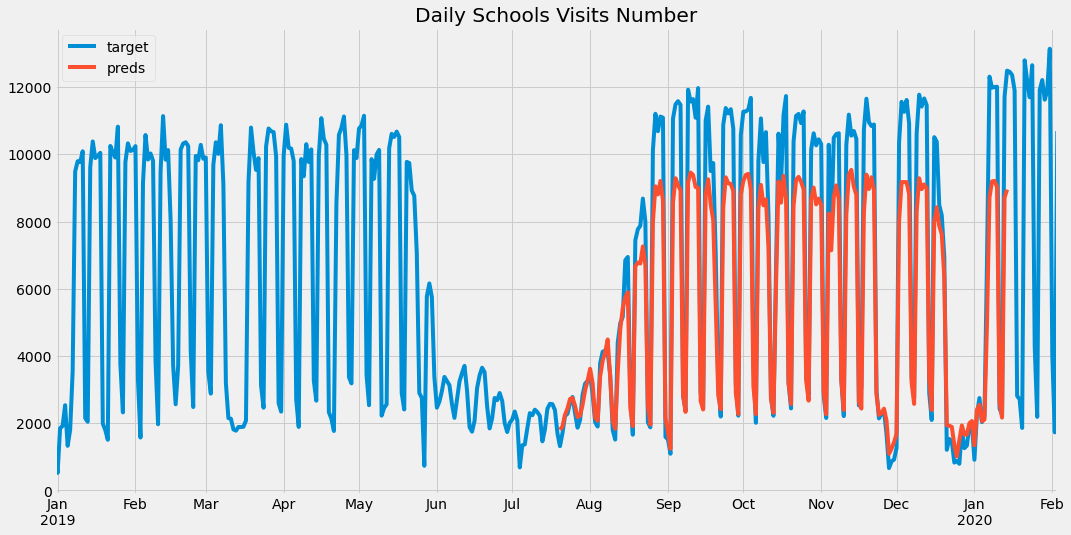

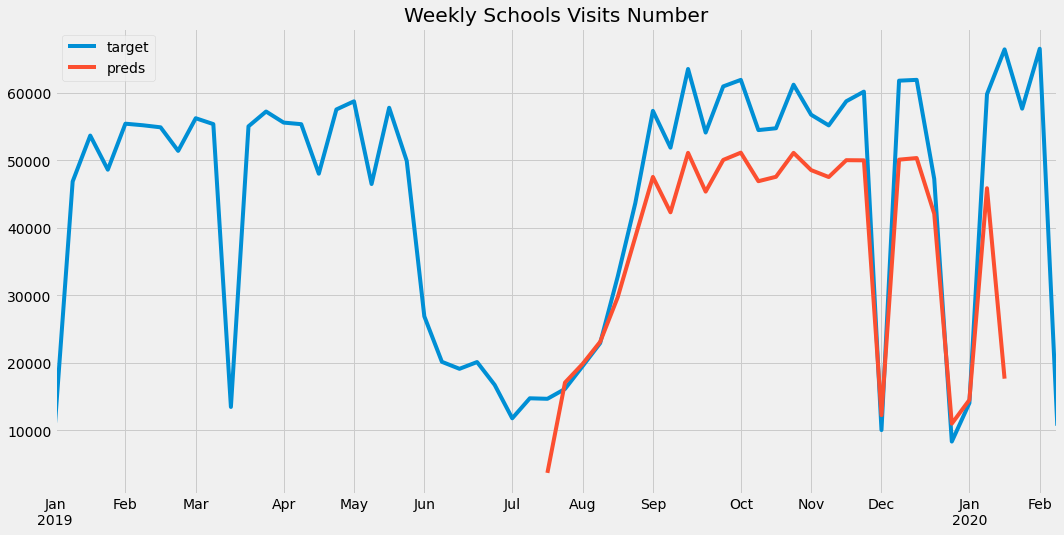

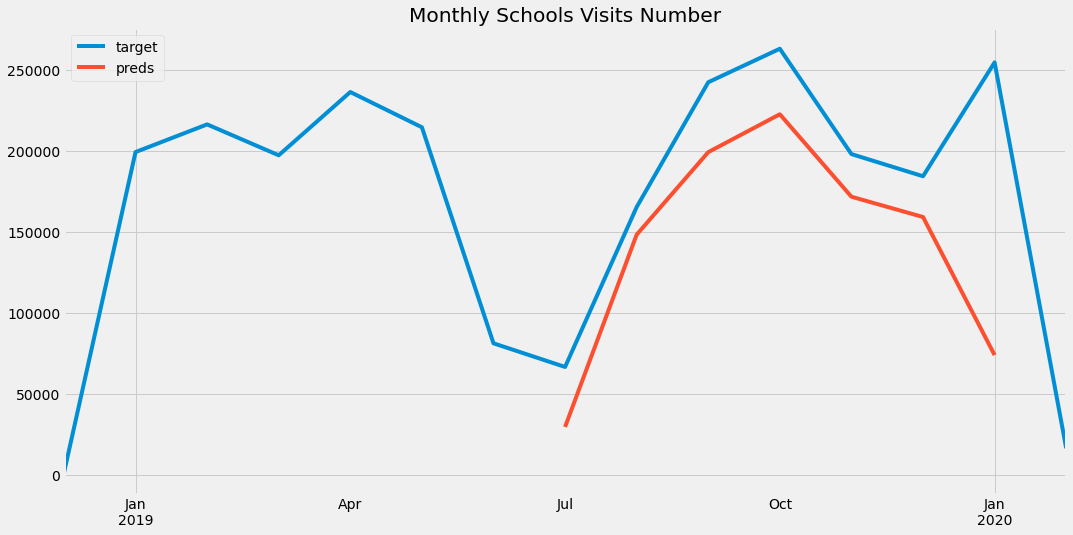

In [43]:
plot_agg_results(sch_df, preds_sch_df, 'Schools')

<AxesSubplot:>

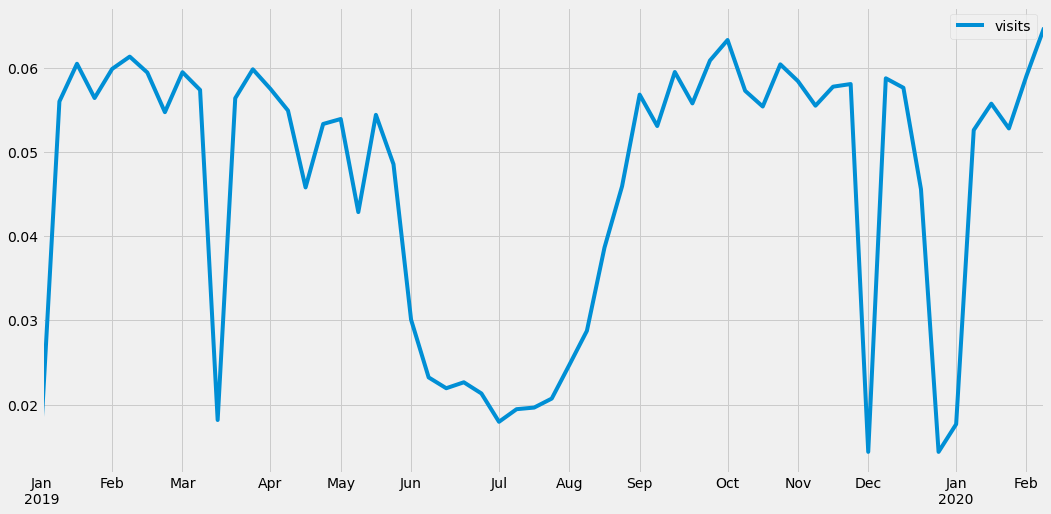

In [44]:
pd.DataFrame(sch_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))

### Checking Restaurants' Visit Patterns

In [45]:
rest_df = get_df_timeseries(agg_df, 'Restaurants and Other Eating Places')
rest_df

,visits
2018-12-31 00:00:00,56
2018-12-31 01:00:00,65
2018-12-31 02:00:00,51
2018-12-31 03:00:00,53
2018-12-31 04:00:00,49
...,...
2020-02-03 19:00:00,198
2020-02-03 20:00:00,138
2020-02-03 21:00:00,114
2020-02-03 22:00:00,80


In [46]:
preds_rest_df = get_preds_timeseries(preds_agg_df, 'Restaurants and Other Eating Places', valid_dates)
preds_rest_df

,visits
2019-07-20 00:00:00,53.507145
2019-07-20 01:00:00,40.79343
2019-07-20 02:00:00,33.430367
2019-07-20 03:00:00,34.052714
2019-07-20 04:00:00,42.438435
...,...
2020-01-14 14:00:00,437.762448
2020-01-14 15:00:00,372.82599
2020-01-14 16:00:00,320.712009
2020-01-14 17:00:00,233.300396


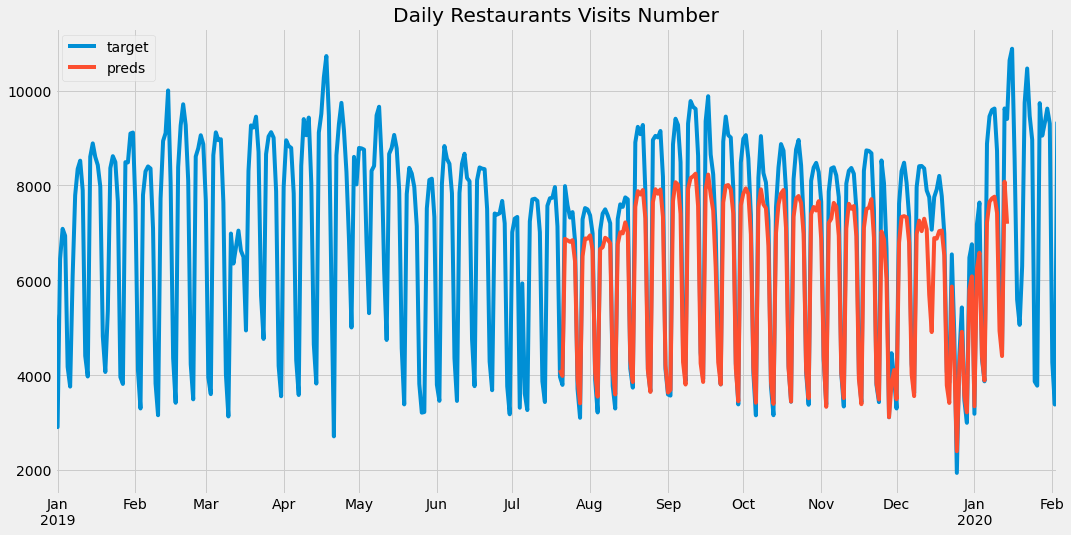

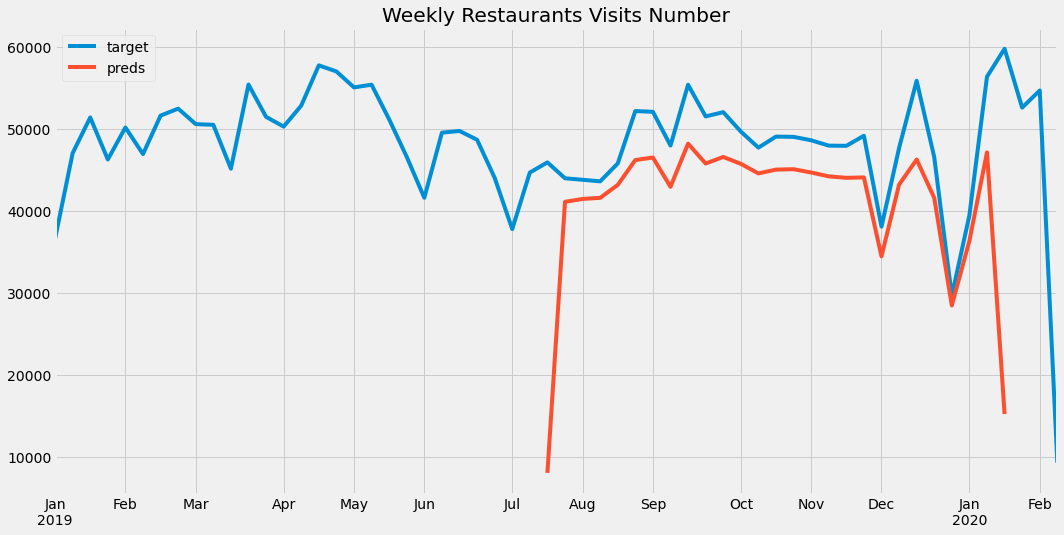

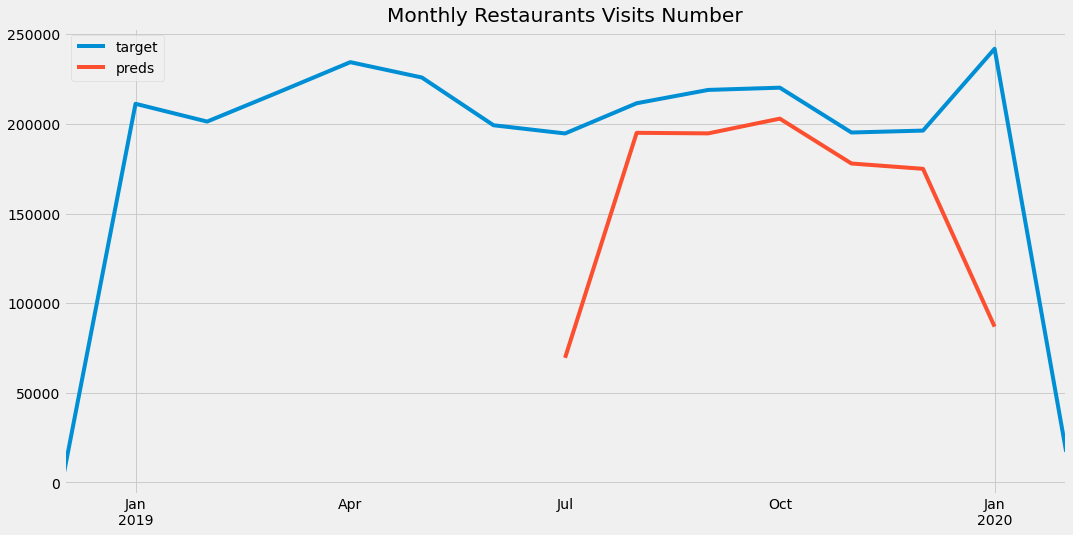

In [47]:
plot_agg_results(rest_df, preds_rest_df, 'Restaurants')

<AxesSubplot:>

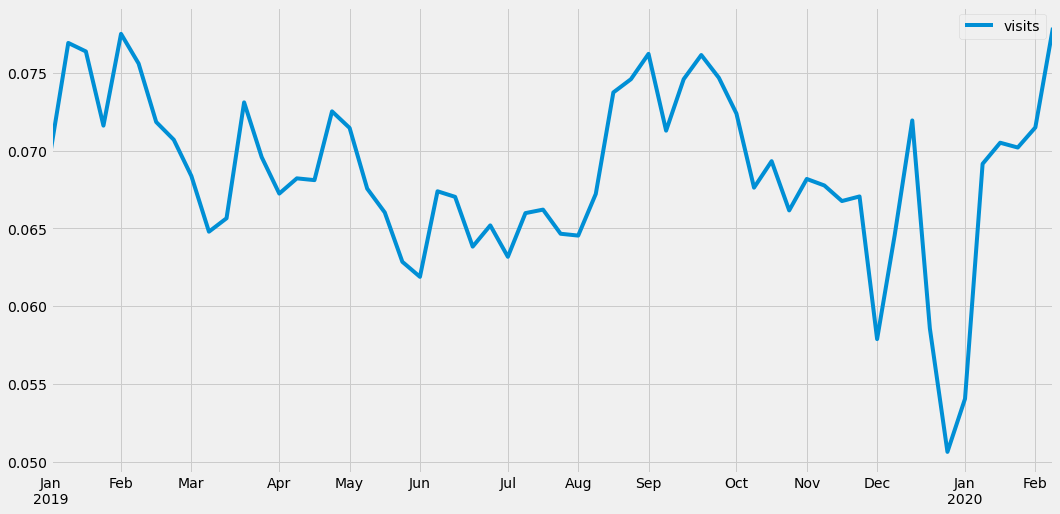

In [49]:
pd.DataFrame(rest_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))